In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et
import re
from collections import Counter

pd.options.display.max_columns = 999

# Florida

## VEST Documentation

Election results from the Florida Department of State (https://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)

Precinct results from several sources.  
- Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  
- Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  
- Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.  
- Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
- Hamilton was drawn based on a geocoded voter registration file.  
- Edits were made to Brevard, Charlotte, Escambia, Franklin, Indian River, Jefferson, Lafayette, Lake, and Lee, Miami-Dade, and St. Johns based on the voter registration file.  

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREODEL - Roque "Rocky" De La Fuente (Reform Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  
G20PREGHAW - Howie Hawkin (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_fl_20 = gp.read_file("./raw-from-source/VEST/mod_vest_clean/mod_vest_clean.shp")

In [3]:
vest_fl_20.columns

Index(['pct_std', 'county', 'precinct', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREODEL', 'G20PRESLAR', 'G20PREGHAW', 'G20PRECBLA',
       'G20PREOWRI', 'COUNTYFP', 'geometry'],
      dtype='object')

In [4]:
data_columns = [col for col in vest_fl_20.columns if "G20" in col]

## Load the Main Primary Election Results

Fields and codes data https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdfF

In [5]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/Election_Results/main_primary/")

#Check that all files have the same number of columns
for i in all_files:
    if i !=".DS_Store" and "recount" not in i:
        ref = "./raw-from-source/Election_Results/main_primary/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        if (file_prev.shape[1]!=19):
            print(i)
        #print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

li = []
for i in all_files:
    if i !=".DS_Store" and "recount" not in i and i != "PAL_PctResults20200818.txt":
        ref = "./raw-from-source/Election_Results/main_primary/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        li.append(file_prev)
prim_frame = pd.concat(li, axis=0, ignore_index=True)
print(prim_frame.shape)

(279939, 19)


In [6]:
frame = prim_frame.copy(deep = True)

In [7]:
sum(prim_frame[(prim_frame[0]=="SEM") & (prim_frame[11] == "State Senator") & (prim_frame[14].str.contains("Ashby"))][18])
sum(prim_frame[(prim_frame[0]=="SEM") & (prim_frame[11] == "State Senator") & (prim_frame[14].str.contains("Carter"))][18])

5787

### Candidates with differences:

PSU09DCAR  
- SEM: 5787 votes precinct file | 5789 votes official results

PSU09DASH  
- SEM: 4314 votes | 4313 votes official results 

https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdf

In [8]:
col_rename_dict = {0: 'County Code (Three-character abbreviation)',
 1: 'County Name',
 2: 'Election Number',
 3: 'Election Date',
 4: 'Election Name',
 5: 'Unique Precinct Identifier',
 6: 'Precinct Polling Location',
 7: 'Total Registered Voters',
 8: 'Total Registered Republicans',
 9: 'Total Registered Democrats',
 10: 'Total Registered All Other Parties',
 11: 'Contest Name',
 12: 'District',
 13: 'Contest Code (Florida’s 6 digit contest codes)',
 14: 'Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes',
 15: 'Candidate Party (abbreviation)',
 16: 'Candidate Florida Voter Registration System ID Number',
 17: 'DOE Assigned Candidate Number or Retention/Issue Number',
 18: 'Vote Total'}

In [9]:
frame.rename(columns = col_rename_dict, inplace = True)

In [10]:
frame["Contest Name"].unique()

array(['State Senator', 'Tax Collector', 'Superintendent of Schools',
       'County Commissioner', 'State Attorney',
       'Clerk of the Circuit Court and Comptroller', 'Sheriff',
       'Property Appraiser', 'School Board', 'Circuit Judge',
       'County Court Judge', 'Representative in Congress',
       'State Representative', 'Public Defender',
       'Port of Palm Beach District', 'Supervisor of Elections',
       'Greater Boca Raton Beach and Park District',
       'Jupiter Inlet District', 'Clerk of the Circuit Court',
       'Lake Region Lakes Management District',
       'Hendry County Hospital Authority',
       'Charlotte County Airport Authority', 'County Council Chair',
       'County Council', 'Mayor', 'Emerald Coast Utilities Authority',
       'Sarasota County Charter Review Board',
       'Sarasota County Public Hospital Board',
       'Lake County Water Authority',
       'North Lake County Hospital District',
       'Ocean Highway and Port Authority', 'City Council

In [11]:
races_list = ['State Senator']

In [12]:
#Filter to the presidential results
frame =frame[frame['Contest Name'].isin(races_list)]

#Filter out the OverVotes and UnderVotes
filtered_frame = frame[~frame['Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes'].isin(['OverVotes', 'UnderVotes'])]

#Clean up the precinct column
filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)

#Deal with Dade County
filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)

#Add in exception for Sarasota - use the precinct polling location
filtered_frame["mod_col"] = np.where(filtered_frame["County Name"]=="Sarasota", filtered_frame["Precinct Polling Location"], filtered_frame["mod_col"])

#Make the precinct column at least 4 digits
filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["pct_std"]=filtered_frame['County Code (Three-character abbreviation)']+filtered_frame["modified_pre"]

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/3274452090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/3274452090.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-c

In [13]:
filtered_frame[filtered_frame["County Name"]=="Hendry"]

,County Code (Three-character abbreviation),County Name,Election Number,Election Date,Election Name,Unique Precinct Identifier,Precinct Polling Location,Total Registered Voters,Total Registered Republicans,Total Registered Democrats,Total Registered All Other Parties,Contest Name,District,Contest Code (Florida’s 6 digit contest codes),Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes,Candidate Party (abbreviation),Candidate Florida Voter Registration System ID Number,DOE Assigned Candidate Number or Retention/Issue Number,Vote Total,mod_col,modified_pre,pct_std


In [14]:
name_update_dict = {}
for i in list(filtered_frame["pct_std"]):
    if (i[0:3] == i[3:6]):
        name_update_dict[i] = i[3:]

In [15]:
filtered_frame["pct_std"]=filtered_frame["pct_std"].map(name_update_dict).fillna(filtered_frame["pct_std"])

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/643207484.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pct_std"]=filtered_frame["pct_std"].map(name_update_dict).fillna(filtered_frame["pct_std"])


In [16]:
# Cast the contest name and code columns to string to make the pivot col
filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/3180966468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/3180966468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)


In [17]:
filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/3279644134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])


In [18]:
filtered_frame['Candidate Party (abbreviation)'].unique()

array(['REP', 'DEM'], dtype=object)

In [19]:
# Create the pivot column with the contest name and the candidate
filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']  

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/1421101604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']


In [20]:
filtered_frame["pivot_col"].value_counts(dropna=False)

State Senator-Benjamin Alexander Thaddeus John Horbowy-PARTY:REP    279
State Senator-Marva Harris Preston-PARTY:REP                        279
State Senator-Daniel "Dan" Horton-Diaz-PARTY:DEM                    226
State Senator-Javier E. Fernandez-PARTY:DEM                         226
State Senator-Tina Polsky-PARTY:DEM                                 208
State Senator-Irving "Irv" Slosberg-PARTY:DEM                       208
State Senator-Perry E. Thurston Jr-PARTY:DEM                        165
State Senator-Shelton A. Pooler-PARTY:DEM                           165
State Senator-Steven Meza-PARTY:DEM                                 165
State Senator-Terry Ann Williams Edden-PARTY:DEM                    165
State Senator-Jason G. Holifield-PARTY:REP                          161
State Senator-Jennifer Bradley-PARTY:REP                            161
State Senator-Shevrin "Shev" Jones-PARTY:DEM                        135
State Senator-Daphne Campbell-PARTY:DEM                         

In [21]:
# Where it exists, add in the district to the pivot column
filtered_frame.loc[:,"pivot_col"] = np.where((filtered_frame["pivot_col"].str.contains("President")), filtered_frame["pivot_col"], filtered_frame["pivot_col"] + "-" + filtered_frame["District"])

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/3878697218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame.loc[:,"pivot_col"] = np.where((filtered_frame["pivot_col"].str.contains("President")), filtered_frame["pivot_col"], filtered_frame["pivot_col"] + "-" + filtered_frame["District"])


In [22]:
filtered_frame["pivot_col"].value_counts(dropna=False)

State Senator-Benjamin Alexander Thaddeus John Horbowy-PARTY:REP-District 3    279
State Senator-Marva Harris Preston-PARTY:REP-District 3                        279
State Senator-Daniel "Dan" Horton-Diaz-PARTY:DEM-District 39                   226
State Senator-Javier E. Fernandez-PARTY:DEM-District 39                        226
State Senator-Tina Polsky-PARTY:DEM-District 29                                208
State Senator-Irving "Irv" Slosberg-PARTY:DEM-District 29                      208
State Senator-Perry E. Thurston Jr-PARTY:DEM-District 33                       165
State Senator-Shelton A. Pooler-PARTY:DEM-District 33                          165
State Senator-Steven Meza-PARTY:DEM-District 33                                165
State Senator-Terry Ann Williams Edden-PARTY:DEM-District 33                   165
State Senator-Jason G. Holifield-PARTY:REP-District 5                          161
State Senator-Jennifer Bradley-PARTY:REP-District 5                            161
Stat

### Pivot the Data

In [23]:
# Removing all of the specific party registration data, as it looks like the state doesn't have that
for val in ['Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties']:
    print(filtered_frame[val].unique())

[ 576  278  109  966  829  836  482 1039  681  602  333  587  608   88
  573  321  779  393  398  352  447  364  139  770  642 1001 1415   87
 1301  392 1754  262  154  376  185  203  276  356  344  295  349  281
   82   27  316   42 1190  241 1423  256  526  170  534  197  217  206
  590  987  828 1240  771  786  508  651  899  972 1003 1176 1285  594
  672  900    0  968 1733 2016  130  401  606 2255  133 1011 1466 1654
  627 1877  288 1111 1741 1373  637  610 1126 1024  292   81  301  636
  389  433  402  117   31  212  205  298  128  357  768 2067 2244 2714
 1831 3302 3172 2060 1770 2295 1993 1337  935 1542 1239  861 1756 2500
 1848 2359 2205 1512 1933 1601 2862 4339 2440 1840 1851  963 1927 1348
 2532 3110  560  699 2053 2899  777  521  267 1795 1107 2183 1410  323
 2139  348  948  403  518  788  826 1812  583  894  773  386 1715  869
 1168  772  300 1119 2178 1390  571 1005 1760 1256  619 1220 1418  516
  120  361 1867  574  661  555  378 1230  285  234  683 1671 1902  549
 2650 

In [24]:
filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/3463717428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)


In [25]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std",'County Code (Three-character abbreviation)','County Name'],columns=['pivot_col'],aggfunc=sum)

#pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std"],columns=['County Code (Three-character abbreviation)','County Name','Total Registered Voters','pivot_col'],aggfunc=sum)


#Clean up the indices
pivoted_2020.reset_index(inplace=True,drop=False)

In [26]:
pivoted_2020.columns

MultiIndex([(                                   'pct_std', ...),
            ('County Code (Three-character abbreviation)', ...),
            (                               'County Name', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (                                'Vote Total', ...),
            (            

In [27]:
pivoted_2020.columns = [' '.join(col).strip() for col in pivoted_2020.columns.values]

In [28]:
pivoted_2020.columns = pivoted_2020.columns.str.replace("Vote Total ","")

In [29]:
pivoted_2020 = pivoted_2020.fillna(0)

## Look into split precincts

In [30]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [31]:
district_cols = [i for i in pivoted_2020.columns if "Representative" in i or "State Senator" in i]

In [32]:
def get_level_dist(column_name):
    zfill_level = 2
    if "Representative in Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
        zfill_level = 3
    else:
        raise ValueError
    return_val = re.findall("District \S*",column_name) 
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
        dist = dist.zfill(zfill_level)
    else:
        raise ValueError
    return level,dist

In [33]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in pivoted_2020.iterrows():
    # print(row)
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            # print(contest)
            precinct_info = get_level_dist(contest)
            # print(precinct_info)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["pct_std"]]=is_split
    precinct_mapping_dict[row["pct_std"]]=precinct_list

In [34]:
split_precincts_list

{'BROG006': {'SU': ['33', '29']}, 'BROG011': {'SU': ['33', '29']}}

In [35]:
precinct_mapping_dict

{'BAK0001': [('SU', '05')],
 'BAK0002': [('SU', '05')],
 'BAK0003': [('SU', '05')],
 'BAK0004': [('SU', '05')],
 'BAK0005': [('SU', '05')],
 'BAK0006': [('SU', '05')],
 'BAK0007': [('SU', '05')],
 'BAK0008': [('SU', '05')],
 'BAK0009': [('SU', '05')],
 'BRA0001': [('SU', '05')],
 'BRA0002': [('SU', '05')],
 'BRA0003': [('SU', '05')],
 'BRA0004': [('SU', '05')],
 'BRA0005': [('SU', '05')],
 'BRA0006': [('SU', '05')],
 'BRA0007': [('SU', '05')],
 'BRA0008': [('SU', '05')],
 'BRA0009': [('SU', '05')],
 'BRA0010': [('SU', '05')],
 'BRA0011': [('SU', '05')],
 'BRA0012': [('SU', '05')],
 'BRA0013': [('SU', '05')],
 'BRA0014': [('SU', '05')],
 'BROA013': [],
 'BROA014': [],
 'BROC005': [('SU', '33')],
 'BROC006': [('SU', '33')],
 'BROC009': [('SU', '33')],
 'BROC015': [('SU', '33')],
 'BROC020': [('SU', '33')],
 'BROC021': [('SU', '33')],
 'BROC023': [('SU', '33')],
 'BROC024': [('SU', '33')],
 'BROC025': [('SU', '33')],
 'BROC026': [('SU', '33')],
 'BROC028': [('SU', '33')],
 'BROC029': [('S

## Rename Columns

In [36]:
pivoted_2020.columns

Index(['pct_std', 'County Code (Three-character abbreviation)', 'County Name',
       'State Senator-Alexis Carter-PARTY:DEM-District 9',
       'State Senator-Barbara Watson-PARTY:DEM-District 35',
       'State Senator-Benjamin Alexander Thaddeus John Horbowy-PARTY:REP-District 3',
       'State Senator-Corinna Balderramos Robinson-PARTY:DEM-District 25',
       'State Senator-Cynthia Ann Stafford-PARTY:DEM-District 35',
       'State Senator-Daniel "Dan" Horton-Diaz-PARTY:DEM-District 39',
       'State Senator-Daphne Campbell-PARTY:DEM-District 35',
       'State Senator-Erhabor Ighodaro-PARTY:DEM-District 35',
       'State Senator-Guerdy Remy-PARTY:DEM-District 9',
       'State Senator-H. Alexander Duncan-PARTY:DEM-District 9',
       'State Senator-Heather Fitzenhagen-PARTY:REP-District 27',
       'State Senator-Irving "Irv" Slosberg-PARTY:DEM-District 29',
       'State Senator-Jason G. Holifield-PARTY:REP-District 5',
       'State Senator-Javier E. Fernandez-PARTY:DEM-Distr

In [37]:
keep_names = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name']

In [38]:
def get_race(contest):
    if "President" in contest:
        level = "PRE"
    elif ("Representative in Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]        
    else:
        print(contest)
        raise ValueError
    return level

In [39]:
def get_party(contest):
    if "PARTY:DEM" in contest:
        return "D"
    elif "PARTY:REP" in contest:
        return "R"
    else:
        print(contest)
        return ValueError

In [40]:
def get_name(contest):
    contest = contest.upper()
    name = contest.split("-")[1]
    likely_last = name.split(" ")[-1]
    if likely_last in ["JR","III","II","SR"]:
        return name.split(" ")[-2][0:3]
    else:
        return likely_last[0:3]

In [41]:
races_list = ['Representative in Congress','State Representative','State Senator']

In [42]:
list(pivoted_2020.columns)

['pct_std',
 'County Code (Three-character abbreviation)',
 'County Name',
 'State Senator-Alexis Carter-PARTY:DEM-District 9',
 'State Senator-Barbara Watson-PARTY:DEM-District 35',
 'State Senator-Benjamin Alexander Thaddeus John Horbowy-PARTY:REP-District 3',
 'State Senator-Corinna Balderramos Robinson-PARTY:DEM-District 25',
 'State Senator-Cynthia Ann Stafford-PARTY:DEM-District 35',
 'State Senator-Daniel "Dan" Horton-Diaz-PARTY:DEM-District 39',
 'State Senator-Daphne Campbell-PARTY:DEM-District 35',
 'State Senator-Erhabor Ighodaro-PARTY:DEM-District 35',
 'State Senator-Guerdy Remy-PARTY:DEM-District 9',
 'State Senator-H. Alexander Duncan-PARTY:DEM-District 9',
 'State Senator-Heather Fitzenhagen-PARTY:REP-District 27',
 'State Senator-Irving "Irv" Slosberg-PARTY:DEM-District 29',
 'State Senator-Jason G. Holifield-PARTY:REP-District 5',
 'State Senator-Javier E. Fernandez-PARTY:DEM-District 39',
 'State Senator-Jennifer Bradley-PARTY:REP-District 5',
 'State Senator-Jim Boy

In [43]:
contest_name_change_dict = {}

In [44]:
duplicate_value_list = []
for contest in pivoted_2020.columns:
    if contest not in keep_names:
        # Add in a condition about the 20
        if "President" in contest:
            value = "P20"+ get_race(contest)+ get_party(contest)+ get_name(contest)
            if value in contest_name_change_dict.values():
                duplicate_value_list.append(value)
            contest_name_change_dict[contest] = value 
        else:
            value = "P"+ get_race(contest)+ get_party(contest)+ get_name(contest)
            if value in contest_name_change_dict.values():
                duplicate_value_list.append(value)
            contest_name_change_dict[contest] = value
#     else:
#         print("'"+contest+"':'',")
if len(duplicate_value_list) > 0:
    print("DUPLICATE VALUES")
    for val in [(k,v) for k, v in contest_name_change_dict.items() if v in duplicate_value_list]:
        print(val)

In [45]:
contest_name_change_dict['Representative in Congress-Ryan D. Chamberlin-PARTY:REP-District 3'] = 'PCON03RCHM'
contest_name_change_dict['Representative in Congress-Todd Chase-PARTY:REP-District 3'] = 'PCON03RCHS'

In [46]:
pivoted_2020.rename(columns=contest_name_change_dict,inplace=True)

In [47]:
df = pd.DataFrame([(v, k.split("-")[1]) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
df.sort_values('Candidate', inplace = True)
#df.to_csv('./non_sw_cand_dict.csv', sep=',')

In [48]:
equal_counties = []
diff_counties_dict = {}
for val in list(pivoted_2020["County Code (Three-character abbreviation)"].unique()):
    elections = pivoted_2020[pivoted_2020["County Code (Three-character abbreviation)"]==val].shape[0]
    vest = vest_fl_20[vest_fl_20["county"]==val].shape[0]
    if (elections != vest):
        diff_counties_dict[val] = [vest,elections]
    else:
        equal_counties.append(val)

In [49]:
diff_counties_dict

{'BRO': [577, 260],
 'DAD': [783, 229],
 'HIL': [390, 56],
 'LEE': [127, 103],
 'LEO': [164, 156],
 'MRN': [122, 7],
 'PAL': [871, 206],
 'SEM': [80, 90],
 'VOL': [125, 11]}

In [50]:
for val in diff_counties_dict.keys():
    print(val)
    join = pd.merge(vest_fl_20[vest_fl_20["county"]==val], pivoted_2020[pivoted_2020["County Code (Three-character abbreviation)"]==val], how = "outer", on = "pct_std", indicator = True)
    
    print(join["_merge"].value_counts())
    print(join[join["_merge"] == "left_only"]["pct_std"])
    
    

BRO
left_only     317
both          260
right_only      0
Name: _merge, dtype: int64
0      BROA001
1      BROA002
2      BROA003
3      BROA004
4      BROA005
        ...   
570    BROY008
573    BROZ003
574    BROZ004
575    BROZ005
576    BROZ073
Name: pct_std, Length: 317, dtype: object
DAD
left_only     554
both          229
right_only      0
Name: _merge, dtype: int64
0      DAD0001
1      DAD0002
2      DAD0003
3      DAD0004
4      DAD0005
        ...   
778    DAD0994
779    DAD0995
780    DAD0996
781    DAD0997
782    DAD0999
Name: pct_std, Length: 554, dtype: object
HIL
left_only     334
both           56
right_only      0
Name: _merge, dtype: int64
0      HIL0101
1      HIL0103
2      HIL0105
3      HIL0107
4      HIL0108
        ...   
385    HIL0980
386    HIL0981
387    HIL0982
388    HIL0983
389    HIL0999
Name: pct_std, Length: 334, dtype: object
LEE
both          103
left_only      24
right_only      0
Name: _merge, dtype: int64
0      LEE0001
1      LEE0002
12     LE

## Filter Columns

In [51]:
list(pivoted_2020.columns)

['pct_std',
 'County Code (Three-character abbreviation)',
 'County Name',
 'PSU09DCAR',
 'PSU35DWAT',
 'PSU03RHOR',
 'PSU25DROB',
 'PSU35DSTA',
 'PSU39DHOR',
 'PSU35DCAM',
 'PSU35DIGH',
 'PSU09DREM',
 'PSU09DDUN',
 'PSU27RFIT',
 'PSU29DSLO',
 'PSU05RHOL',
 'PSU39DFER',
 'PSU05RBRA',
 'PSU21RBOY',
 'PSU21RHOU',
 'PSU03RPRE',
 'PSU09DSIG',
 'PSU33DTHU',
 'PSU27RROD',
 'PSU25DDIA',
 'PSU09DASH',
 'PSU33DPOO',
 'PSU35DJON',
 'PSU33DMEZ',
 'PSU33DEDD',
 'PSU29DPOL',
 'PSU35DHAR']

In [52]:
keep_columns = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name']

state_data_columns = [i for i in pivoted_2020.columns if i not in keep_columns]

pivoted_2020_sldl = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("PSL" in i)]]
pivoted_2020_sldu = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("PSU" in i)]]
pivoted_2020_cong = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("PCON" in i)]]

### Precinct-by-Precinct Check

In [53]:
#Check if the columns are unique
print(vest_fl_20["pct_std"].value_counts(dropna=False))
print(pivoted_2020["pct_std"].value_counts(dropna=False))

ALA0001    1
DAD0122    1
DAD0131    1
DAD0130    1
DAD0129    1
          ..
ORA0536    1
ORA0535    1
ORA0534    1
ORA0533    1
CLL0416    1
Name: pct_std, Length: 6011, dtype: int64
BAK0001    1
MAN0317    1
MAN0313    1
MAN0311    1
MAN0309    1
          ..
DAD0888    1
DAD0856    1
DAD0853    1
DAD0852    1
WAK0012    1
Name: pct_std, Length: 1590, dtype: int64


In [54]:
ser = pivoted_2020["pct_std"].value_counts(dropna=False)

In [55]:
dup_ids = ser[ser > 1].index

In [56]:
data_columns_full = [i for i in pivoted_2020.columns if i not in ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','REG_VOTERS',"county"]]

In [57]:
# #Combine results in these two precincts to match VEST
# pivoted_2020_st =pivoted_2020_st.fillna(0)
# for i in state_data_columns:
#     print(i)
#     pivoted_2020_st[i] = pivoted_2020_st[i].astype(int)
    
#     pivoted_2020_st.loc[pivoted_2020_st["pct_std"]=="CHA54.0",i]+=int(pivoted_2020_st.loc[pivoted_2020_st["pct_std"]=="CHA54.1",i])

# #Check that it works
# pivoted_2020_st.loc[pivoted_2020_st["pct_std"]=="CHA54.0"]

# #Remove the precinct that the votes were added from
# pivoted_2020_st = pivoted_2020_st[pivoted_2020_st["pct_std"]!="CHA54.1"]

### Allocate votes

From VEST's documentation:

> Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

In [58]:
election_vest_id_changes = pd.read_csv("./raw-from-source/st_id_changes_dict_non_sw.csv")
election_vest_id_changes_dict = dict(zip(election_vest_id_changes["primary_ID"],election_vest_id_changes["vest_ID"]))


    

In [59]:
pivoted_2020["pct_std"] = pivoted_2020["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020["pct_std"])

In [60]:
join_attempt_one = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
print(join_attempt_one["_merge"].value_counts())



left_only     4431
both          1580
right_only      10
Name: _merge, dtype: int64


# Completed: Counties to look into:
- PAL
    - The votes from these precincts just need to be allocated
- HEN
    - The confusing thing about Hendado is "10 - PRE01" vs "1 - PRE10"
    - Primary file:
        - What is called "10 - PRE01" in primary has votes for County Commissioner District 1
        - What is called "1 - PRE10" in primary has votes for County Commissioner District 4
    - General file:
        - No county commissioner district 1 results in the general
        - What is called "10 - PRE010" in general has votes for County Commissioner District 4
    - Go by the precinct # for these

## Look into unjoined VEST votes, make sure they make sense

In [61]:
counties_w_unjoined = list(join_attempt_one[join_attempt_one["_merge"]=="left_only"]["county"].unique())

join_attempt_one[join_attempt_one["_merge"]=="left_only"]["county"].value_counts()

PAL    665
DAD    554
HIL    334
BRO    317
PIN    301
ORA    247
DUV    199
BRE    173
POL    167
MRN    115
VOL    114
PAS    112
LAK    103
SAR    101
OSC    100
ESC     80
CHA     67
ALA     63
CLL     61
OKA     52
STJ     48
BAY     44
SAN     41
IND     35
PUT     35
HER     32
CIT     31
SUM     26
FLA     26
HIG     25
LEE     24
WAL     21
NAS     15
DES     15
JAC     14
GLA     13
WAS     12
HAR     12
OKE     11
HEN     10
HOL      8
LEO      8
Name: county, dtype: int64

In [62]:
for county in counties_w_unjoined:
    print(county)
    print(vest_fl_20[vest_fl_20["county"]==county].shape)
    print(join_attempt_one[(join_attempt_one["_merge"]=="left_only") & (join_attempt_one["county"]==county)].shape)

ALA
(63, 13)
(63, 45)
BAY
(44, 13)
(44, 45)
BRO
(577, 13)
(317, 45)
CHA
(67, 13)
(67, 45)
CIT
(31, 13)
(31, 45)
DES
(15, 13)
(15, 45)
FLA
(26, 13)
(26, 45)
GLA
(13, 13)
(13, 45)
HAR
(12, 13)
(12, 45)
HEN
(10, 13)
(10, 45)
HER
(32, 13)
(32, 45)
HIG
(25, 13)
(25, 45)
HIL
(390, 13)
(334, 45)
HOL
(8, 13)
(8, 45)
JAC
(14, 13)
(14, 45)
LEE
(127, 13)
(24, 45)
NAS
(15, 13)
(15, 45)
OKA
(52, 13)
(52, 45)
OKE
(11, 13)
(11, 45)
ORA
(247, 13)
(247, 45)
PIN
(301, 13)
(301, 45)
POL
(167, 13)
(167, 45)
PUT
(35, 13)
(35, 45)
SAN
(41, 13)
(41, 45)
SAR
(101, 13)
(101, 45)
SUM
(26, 13)
(26, 45)
WAL
(21, 13)
(21, 45)
WAS
(12, 13)
(12, 45)
BRE
(173, 13)
(173, 45)
CLL
(61, 13)
(61, 45)
DUV
(199, 13)
(199, 45)
ESC
(80, 13)
(80, 45)
IND
(35, 13)
(35, 45)
LAK
(103, 13)
(103, 45)
LEO
(164, 13)
(8, 45)
MRN
(122, 13)
(115, 45)
DAD
(783, 13)
(554, 45)
PAL
(871, 13)
(665, 45)
STJ
(48, 13)
(48, 45)
VOL
(125, 13)
(114, 45)
PAS
(112, 13)
(112, 45)
OSC
(100, 13)
(100, 45)


## Allocate Votes

In [63]:
for val in list(join_attempt_one[join_attempt_one["_merge"]=="right_only"]["pct_std"]):
    print(val)

SEM0081
SEM0082
SEM0083
SEM0084
SEM0085
SEM0086
SEM0087
SEM0088
SEM0089
SEM0090


In [64]:
sem_diff = pd.DataFrame(0, index=np.arange(1), columns = pivoted_2020.columns)
sem_diff["pct_std"] = "SEMDIFF"
sem_diff["County Code (Three-character abbreviation)"] = "SEM"
sem_diff["County Name"] = "Seminole"

In [65]:
sem_diff["PSU09DCAR"] = 2
sem_diff["PSU09DASH"] = -1

In [66]:
pivoted_2020 = pd.concat([pivoted_2020, sem_diff], ignore_index = True, axis = 0)

### Candidates with differences:

PSU09DCAR  
- SEM: 5787 votes precinct file | 5789 votes official results

PSU09DASH  
- SEM: 4314 votes | 4313 votes official results 

In [67]:
# extra_to_allocate = pd.read_csv("./raw-from-source/Election_Results/pivot_to_build_allocation.csv")
# pivoted_2020_st = pd.concat([pivoted_2020_st, extra_to_allocate])
to_allocate = ['FLA0999',
 'LAK0108',
 'OSC0999',
 'PAL8001',
 'PAL8002',
'SEM0081',
'SEM0082',
'SEM0083',
'SEM0084',
'SEM0085',
'SEM0086',
'SEM0087',
'SEM0088',
'SEM0089',
'SEM0090',
'BRE0999','DAD0100','BROZ073','CHA0054','CLL0450','HIL0999','LEO9000','PIN0512', "SEMDIFF"]

In [68]:
allocating_votes = pivoted_2020[pivoted_2020["pct_std"].isin(to_allocate)]
receiving_votes = pivoted_2020[~pivoted_2020["pct_std"].isin(to_allocate)]

In [69]:
allocating_votes

,pct_std,County Code (Three-character abbreviation),County Name,PSU09DCAR,PSU35DWAT,PSU03RHOR,PSU25DROB,PSU35DSTA,PSU39DHOR,PSU35DCAM,PSU35DIGH,PSU09DREM,PSU09DDUN,PSU27RFIT,PSU29DSLO,PSU05RHOL,PSU39DFER,PSU05RBRA,PSU21RBOY,PSU21RHOU,PSU03RPRE,PSU09DSIG,PSU33DTHU,PSU27RROD,PSU25DDIA,PSU09DASH,PSU33DPOO,PSU35DJON,PSU33DMEZ,PSU33DEDD,PSU29DPOL,PSU35DHAR
998,LEO9000,LEO,Leon,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1455,SEM0081,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,SEM0082,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,SEM0083,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,SEM0084,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1459,SEM0085,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1460,SEM0086,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1461,SEM0087,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1462,SEM0088,SEM,Seminole,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
1463,SEM0089,SEM,Seminole,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
receiving_votes.head()

,pct_std,County Code (Three-character abbreviation),County Name,PSU09DCAR,PSU35DWAT,PSU03RHOR,PSU25DROB,PSU35DSTA,PSU39DHOR,PSU35DCAM,PSU35DIGH,PSU09DREM,PSU09DDUN,PSU27RFIT,PSU29DSLO,PSU05RHOL,PSU39DFER,PSU05RBRA,PSU21RBOY,PSU21RHOU,PSU03RPRE,PSU09DSIG,PSU33DTHU,PSU27RROD,PSU25DDIA,PSU09DASH,PSU33DPOO,PSU35DJON,PSU33DMEZ,PSU33DEDD,PSU29DPOL,PSU35DHAR
0,BAK001A,BAK,Baker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219.0,0.0,262.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BAK002A,BAK,Baker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,413.0,0.0,460.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BAK003A,BAK,Baker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,444.0,0.0,513.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BAK004A,BAK,Baker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BAK004B,BAK,Baker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0,121.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [72]:
#Perform the allocation
pivoted_2020 = allocate_absentee(receiving_votes,allocating_votes,state_data_columns,'County Name',allocating_to_all_empty_precs=False)

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/2056752905.py:27: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/2056752905.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/2056752905.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is depre

In [73]:
join_attempt_two = pd.merge(vest_fl_20,pivoted_2020,how="outer",on="pct_std",indicator=True)
join_attempt_two["_merge"].value_counts()

left_only     4432
both          1579
right_only       0
Name: _merge, dtype: int64

In [74]:
join_attempt_two = join_attempt_two[join_attempt_two["_merge"] == "both"]

In [75]:
## Add in a "SLDU_DIST" column

In [76]:
join_attempt_two["Tot_Votes"] = 0

for race in state_data_columns:
    join_attempt_two["Tot_Votes"] += join_attempt_two[race]

In [77]:
def contains_sldu(dist_list):
    for dist_tuple in dist_list:
        if dist_tuple[0] == "SU":
            return dist_tuple[1]

In [78]:
#Need to update the precinct_mapping_dict
updated_precinct_mapping_dict = {}

for val in precinct_mapping_dict.keys():
    if val in election_vest_id_changes_dict.keys():
        updated_precinct_mapping_dict[election_vest_id_changes_dict[val]] = precinct_mapping_dict[val]
    else:
        updated_precinct_mapping_dict[val] = precinct_mapping_dict[val]

check_list = {i:contains_sldu(updated_precinct_mapping_dict[i]) for i in updated_precinct_mapping_dict.keys()}

In [79]:
#Update split precincts list
updated_split_precincts_list = {}

for val in split_precincts_list.keys():
    if val in election_vest_id_changes_dict.keys():
        updated_split_precincts_list[election_vest_id_changes_dict[val]] = split_precincts_list[val]
    else:
        updated_split_precincts_list[val] = split_precincts_list[val]

In [80]:
join_attempt_two["SLDU_DIST"] = join_attempt_two["pct_std"].map(check_list).fillna("n/a")

## Deal with split precincts

In [81]:
# Load shapefile
fl_sldu_shapefile = gp.read_file("./raw-from-source/District_Shapefiles/fl_pl2020_sldu/fl_pl2020_sldu.shp")

In [82]:
fl_sldu_shapefile = fl_sldu_shapefile.to_crs(vest_fl_20.crs)
fl_sldu_shapefile["SLDUST"] = fl_sldu_shapefile["SLDUST20"].str[1:3]

In [83]:
def return_sldu_splits(split_dict):
    for val in split_dict.keys():
        if 'SU' in val:
            return split_dict['SU']

In [84]:
sldu_splits_dict = {i:return_sldu_splits(updated_split_precincts_list[i]) for i in updated_split_precincts_list.keys() if return_sldu_splits(updated_split_precincts_list[i]) != None }

In [85]:
def district_splits(cd_list, level, old_name, elections_gdf, shps_gdf, unique_ID_col, district_ID, races_list, dist_column):
    full_shape = elections_gdf.loc[elections_gdf[unique_ID_col]==old_name]
    for index in range(0,len(cd_list)):
        district = shps_gdf.loc[shps_gdf[district_ID]==cd_list[index]]
        new_prec = gp.overlay(full_shape, district, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging District: ",cd_list[index],"and prec:",old_name,"***")
            print(full_shape)
            ax = full_shape.boundary.plot(figsize=(20,20))
        new_prec = new_prec[list(elections_gdf.columns)]
        for column in new_prec:
            if column in races_list and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec[unique_ID_col]=old_name+"-("+level+"-"+cd_list[index]+")"
        new_prec[dist_column] = cd_list[index]
        elections_gdf = elections_gdf.append(new_prec)
        elections_gdf.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    elections_gdf = elections_gdf[elections_gdf[unique_ID_col] != old_name]
    elections_gdf.reset_index(drop=True,inplace=True)
    return elections_gdf

In [86]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in join_attempt_two["pct_std"]:
    cd_list = []
    if val in sldu_splits_dict.keys() and val not in to_allocate:
        print(val, "=>", sldu_splits_dict[val])
        join_attempt_two = district_splits(sldu_splits_dict[val],"SU",val, join_attempt_two, fl_sldu_shapefile, "pct_std", "SLDUST", state_data_columns, "SLDU_DIST")
        

BROG006 => ['33', '29']
BROG011 => ['33', '29']


/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/geoseries.py:843: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for idx, s in self.geometry.iteritems():
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/228858465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_prec.loc[0:,column] = 0
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/228858465.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_

In [87]:
join_attempt_two["UNIQUE_ID"] = join_attempt_two["pct_std"]

In [88]:
fl_sldu_shapefile["SLDU_DIST"] = fl_sldu_shapefile["SLDUST"]
fl_sldu_shapefile = fl_sldu_shapefile[fl_sldu_shapefile["SLDU_DIST"].isin(list(join_attempt_two["SLDU_DIST"].unique()))]

In [89]:
join_attempt_two["geometry"] = join_attempt_two["geometry"].buffer(0)

In [90]:
join_attempt_two.drop("_merge", axis = 1, inplace = True)

In [91]:
filtered_results = join_attempt_two[join_attempt_two["SLDU_DIST"]!="n/a"].dissolve("SLDU_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [92]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 10 precincts for differences of greater than 0.1 km^2

1) For 21 difference in area is 61.72316415695033
2) For 27 difference in area is 239.9178262917951
3) For 09 difference in area is 22.597573625570156
4) For 33 difference in area is 0.9896306997424122
5) For 25 difference in area is 180.59640511828874
6) For 35 difference in area is 1.9492302216499153
7) For 39 difference in area is 423.93390822005523
8) For 03 difference in area is 384.87132759512446
9) For 29 difference in area is 248.45506785957127
10) For 05 difference in area is 219.89453356585256

Scroll down to see plots of any differences

Of the 10 precincts:

0 precincts w/ a difference of 0 km^2
0 precincts w/ a difference between 0 and .1 km^2
0 precincts w/ a difference between .1 and .5 km^2
1 precincts w/ a difference between .5 and 1 km^2
1 precincts w/ a difference between 1 and 2 km^2
0 precincts w/ a difference between 2 and 5 km^2
8 precincts w/ a difference greater than 5 km^2


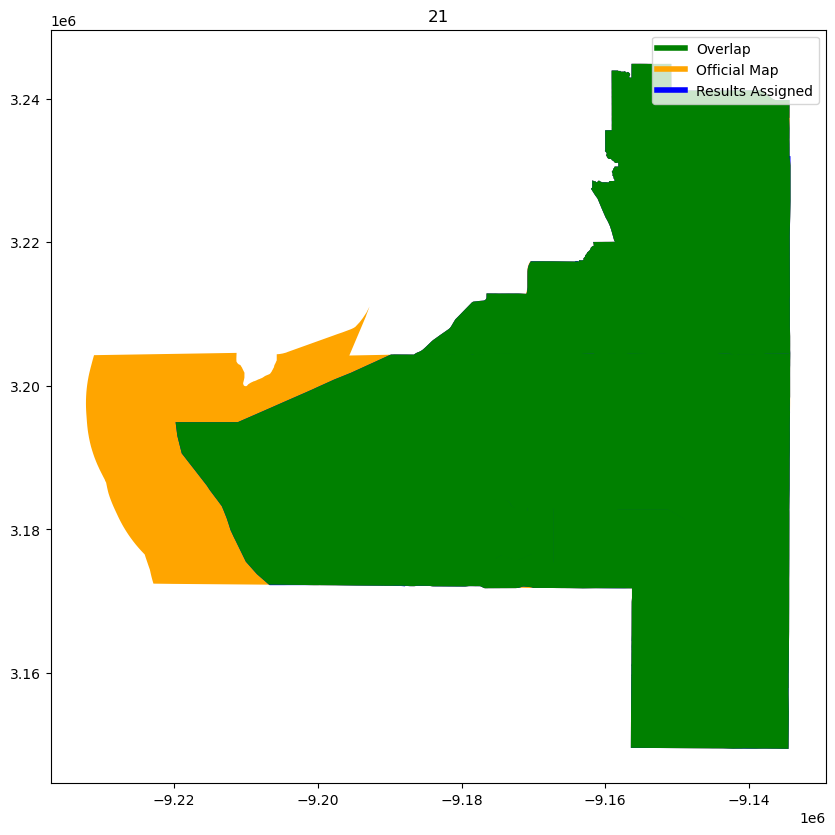

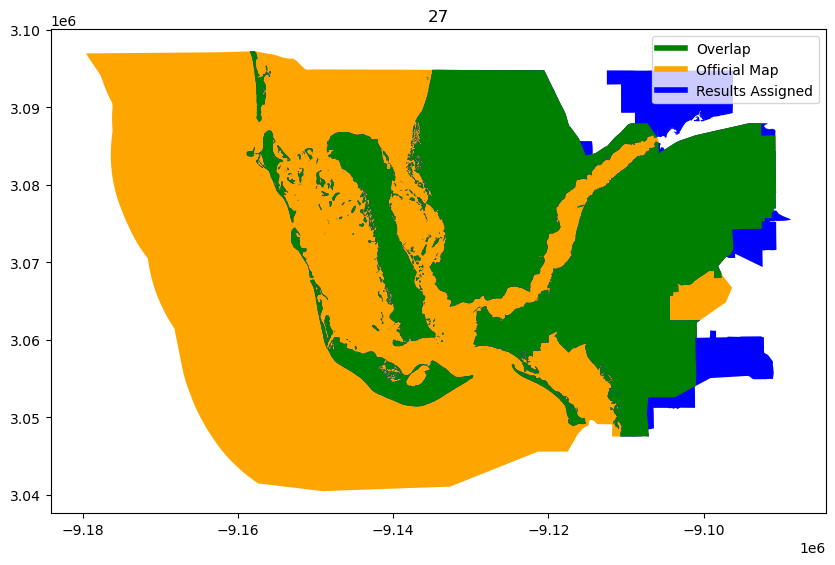

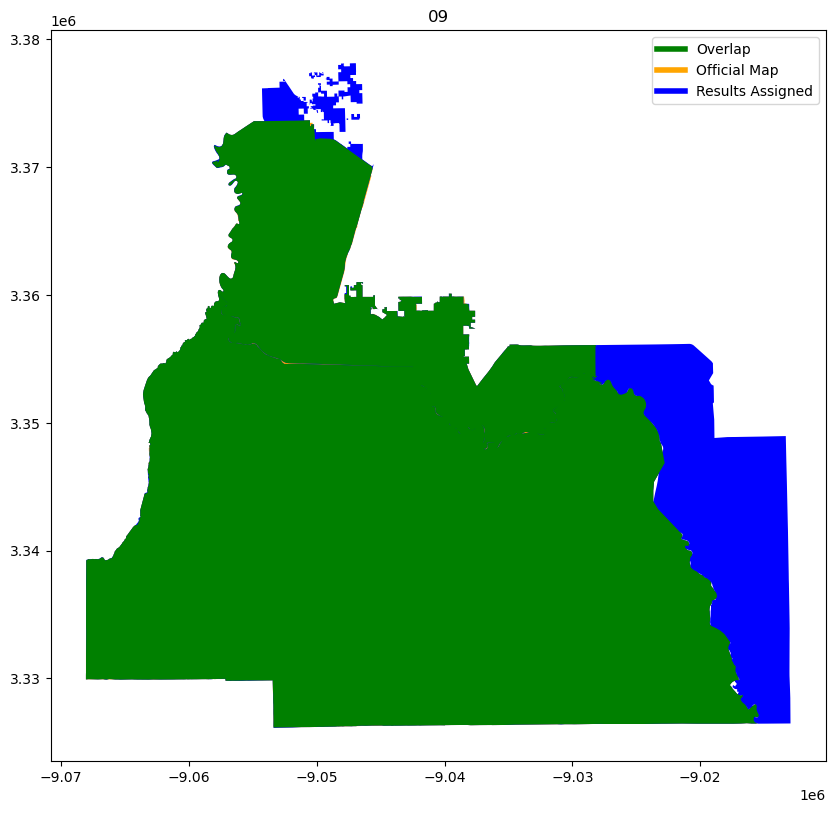

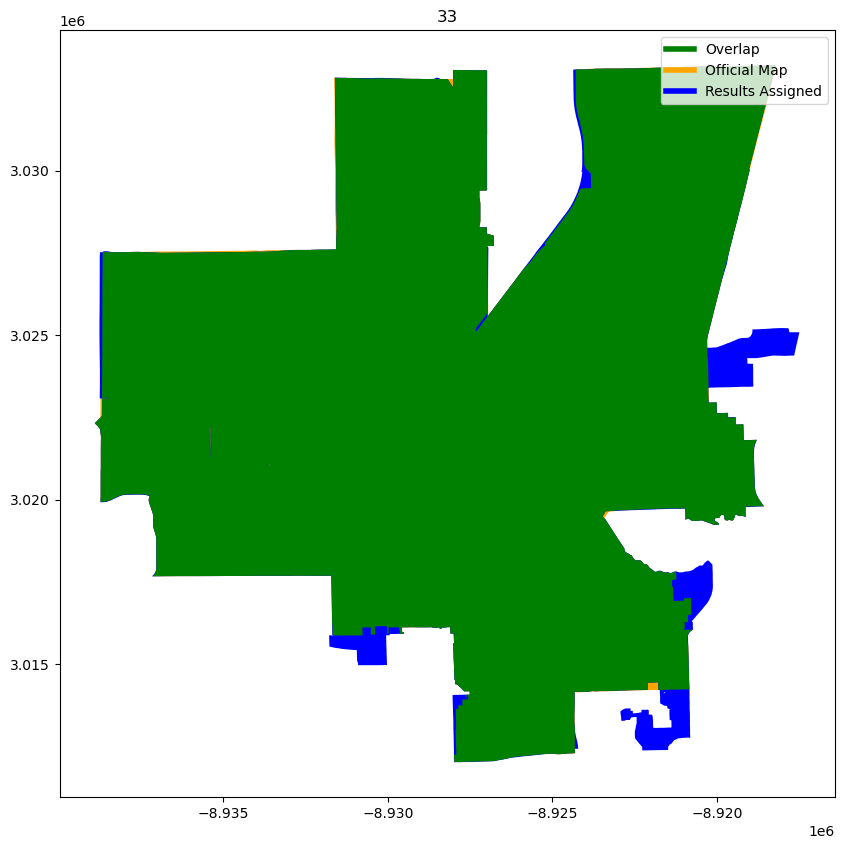

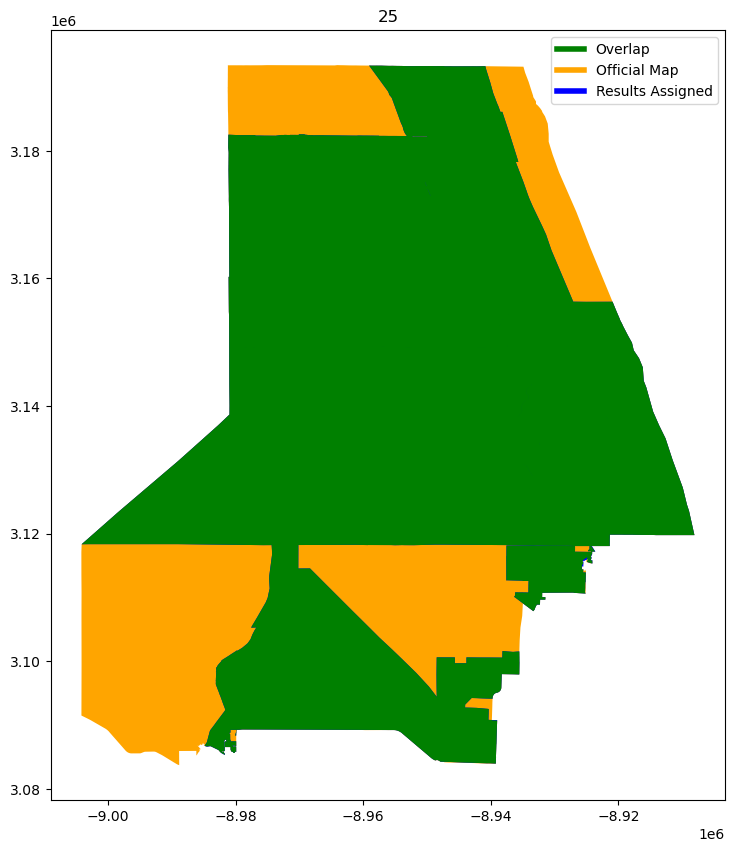

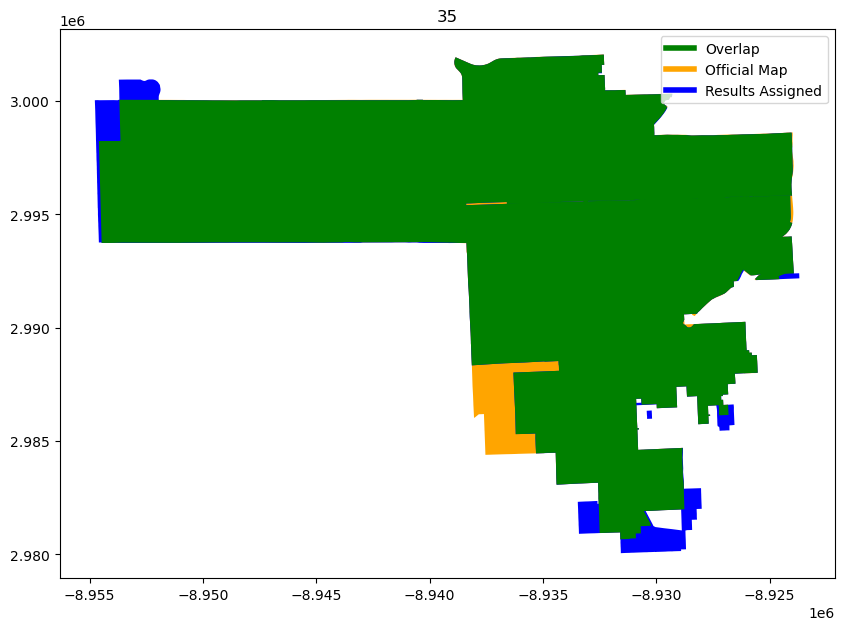

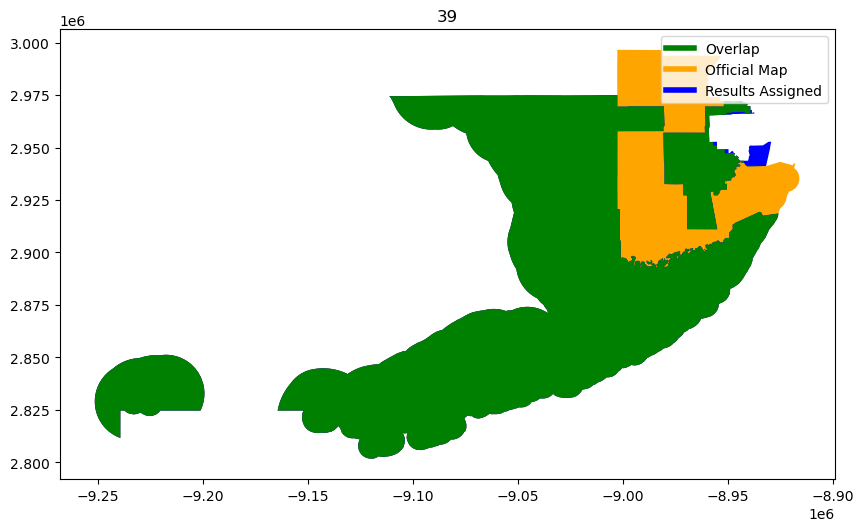

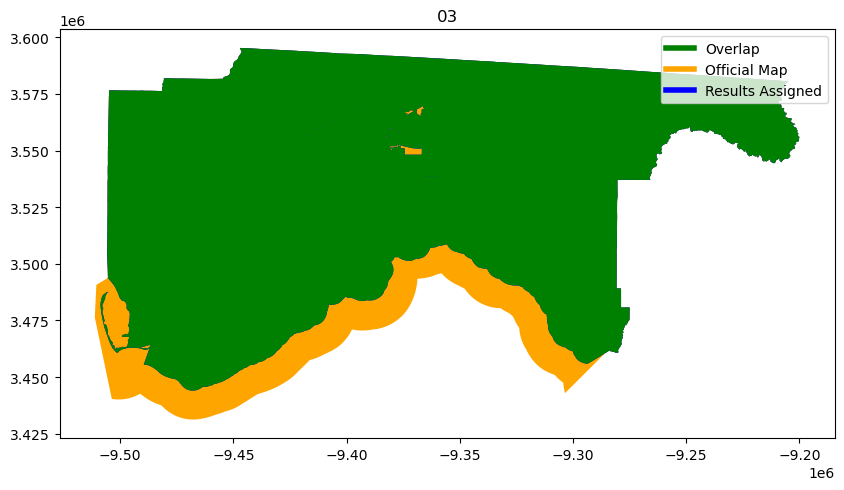

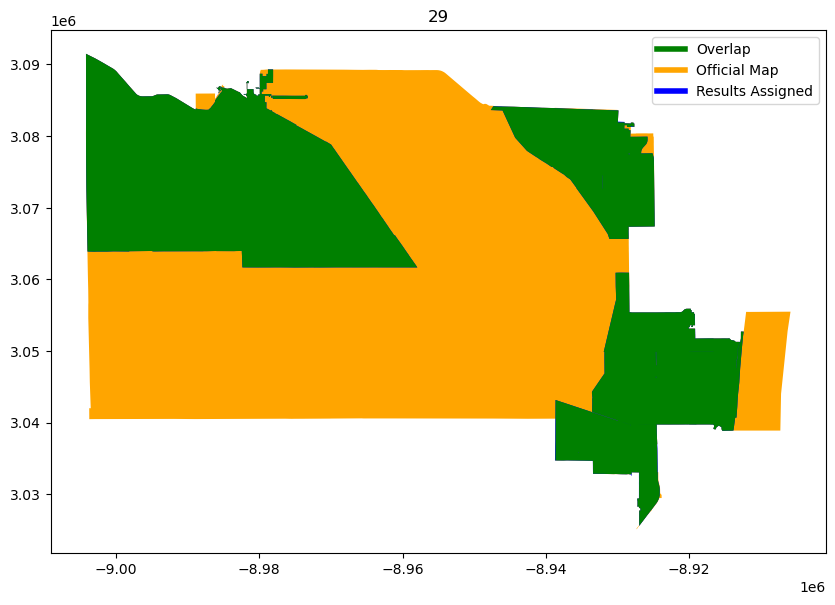

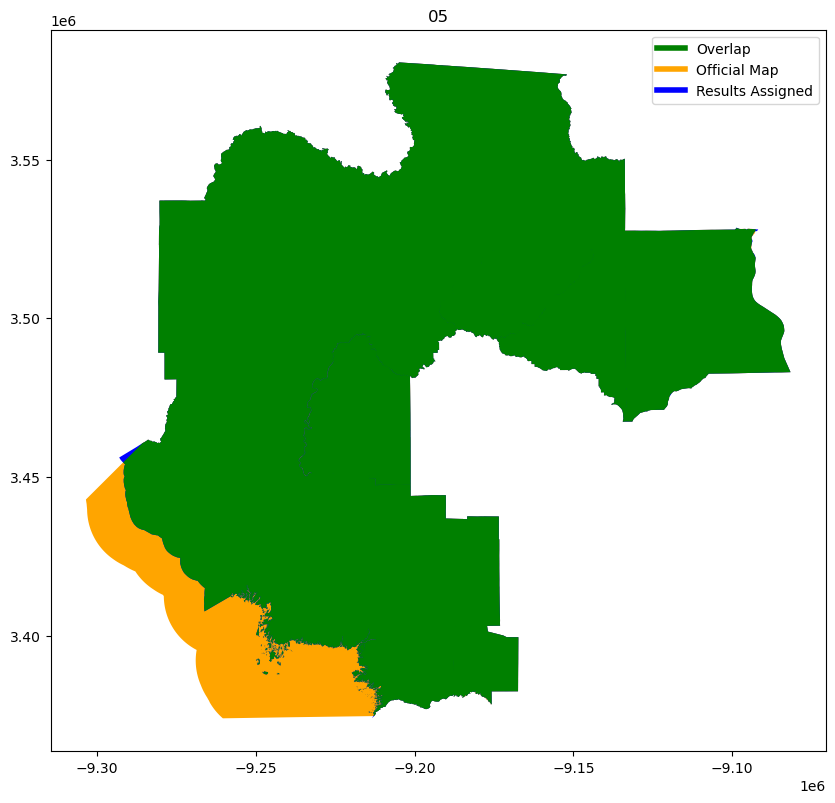

In [93]:
compare_geometries(fl_sldu_shapefile,filtered_results,"Official Map","Results Assigned","SLDU_DIST",area_threshold=.1)

## Add County FIPS column

In [94]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Florida"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"]=fips_file["County Name"].map({'De Soto':'Desoto','St Lucie':'St. Lucie', 'St Johns':'St. Johns'}).fillna(fips_file["County Name"])

#Create the dictionary
fl_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))



In [95]:
join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict).fillna(join_attempt_two["County Name"])

fl_fips_dict_2 = {
  'BRO':'011',
  'FLA':'035',
  'HIL':'057',
  'PIN':'103',
  'BRE':'009',
  'CLL':'021',
  'LEO':'073',
  'DAD':'086',
  'PAL':'099',
  'PAS':'101',
}

join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict_2).fillna(join_attempt_two["COUNTYFP"])

join_attempt_two["COUNTYFP"].unique()

array(['007', '011', '013', '019', '023', '029', '037', '039', '041',
       '057', '065', '067', '071', '075', '077', '079', '081', '117',
       '111', '121', '123', '125', '129', '003', '045', '047', '073',
       '083', '085', '086', '087', '099', '127'], dtype=object)

## Election Totals Checks

In [96]:
join_attempt_two = join_attempt_two.fillna(0)
for val in state_data_columns:
    join_attempt_two[val] = join_attempt_two[val].astype(int)

state_data_columns.sort()

In [97]:
official_totals = pd.read_csv("./raw-from-source/Election_Results/totals/08182020Election (1).txt",sep="\t",engine='python',index_col=None)

official_totals = official_totals[official_totals["OfficeDesc"].isin(['United States Representative','State Senator', 'State Representative'])]

office_rename_dict = {'United States Representative':'PCONG',
 'State Senator':'PSU',
 'State Representative':'PSL'}

official_totals["OfficeDesc"] = official_totals["OfficeDesc"].map(office_rename_dict).fillna(official_totals["OfficeDesc"])

official_totals["Juris1num"] = official_totals["Juris1num"].astype(str)
official_totals["Juris1num"] = official_totals["Juris1num"].str.zfill(3)

official_totals["Juris1num"] = np.where(official_totals["OfficeDesc"]=="PCONG", official_totals["Juris1num"].str[1:], official_totals["Juris1num"])
official_totals["Juris1num"] = np.where(official_totals["OfficeDesc"]=="PSU", official_totals["Juris1num"].str[1:], official_totals["Juris1num"])

official_totals.loc[official_totals["CanNameLast"]=="Chamberlin",'CanNameLast'] = "Chmberlin"
official_totals.loc[official_totals["CanNameLast"]=="Chase",'CanNameLast'] = 'Chse'

official_totals.loc[official_totals["CanNameLast"]=="Balderramos Robinson",'CanNameLast'] = "Robinson"

official_totals["CanNameLast_mod"] = official_totals["CanNameLast"].str[0:3].str.upper()

official_totals["cand_col_mod"] = official_totals["OfficeDesc"]+official_totals["Juris1num"]+official_totals["PartyCode"].str[0]+official_totals["CanNameLast_mod"]

official_totals_pivoted = pd.pivot_table(official_totals, index = 'CountyCode', columns = "cand_col_mod", values = "CanVotes", aggfunc = sum)

official_totals_pivoted.reset_index(inplace=True,drop=False)

official_totals_pivoted.rename(columns={"CountyCode" : "county"}, inplace = True)

official_totals_pivoted = official_totals_pivoted.fillna(0)

official_totals_pivoted.columns

state_senate_cols = [i for i in official_totals_pivoted.columns if "PSU" in i]

official_totals_pivoted = official_totals_pivoted[["county"]+state_senate_cols]

official_totals_pivoted["Tot_Votes"] = 0
for col in state_senate_cols:
    official_totals_pivoted["Tot_Votes"] += official_totals_pivoted[col]
    
official_totals_pivoted = official_totals_pivoted[official_totals_pivoted["Tot_Votes"] > 0]


In [98]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tOfficial Totals: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tPrecinct Results: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
    if (len(diff_counties)>0):
        print()
        print(diff_counties)

In [99]:
county_totals_check(official_totals_pivoted, join_attempt_two , state_data_columns,"county",full_print=False)

***Countywide Totals Check***

PSU03RHOR is equal across all counties
PSU03RPRE is equal across all counties
PSU05RBRA is equal across all counties
PSU05RHOL is equal across all counties
PSU09DASH is equal across all counties
PSU09DCAR is equal across all counties
PSU09DDUN is equal across all counties
PSU09DREM is equal across all counties
PSU09DSIG is equal across all counties
PSU21RBOY is equal across all counties
PSU21RHOU is equal across all counties
PSU25DDIA is equal across all counties
PSU25DROB is equal across all counties
PSU27RFIT is equal across all counties
PSU27RROD is equal across all counties
PSU29DPOL is equal across all counties
PSU29DSLO is equal across all counties
PSU33DEDD is equal across all counties
PSU33DMEZ is equal across all counties
PSU33DPOO is equal across all counties
PSU33DTHU is equal across all counties
PSU35DCAM is equal across all counties
PSU35DHAR is equal across all counties
PSU35DIGH is equal across all counties
PSU35DJON is equal across all cou

/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
/var/folders/1t/0q4w6hm92mg_zxd84dfxmq3m0000gn/T/ipykernel_27016/342596112.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated

### Note: In order to make these differences match, the following votes were added /subtracted in Seminole county above

In [100]:
sem_diff

,pct_std,County Code (Three-character abbreviation),County Name,PSU09DCAR,PSU35DWAT,PSU03RHOR,PSU25DROB,PSU35DSTA,PSU39DHOR,PSU35DCAM,PSU35DIGH,PSU09DREM,PSU09DDUN,PSU27RFIT,PSU29DSLO,PSU05RHOL,PSU39DFER,PSU05RBRA,PSU21RBOY,PSU21RHOU,PSU03RPRE,PSU09DSIG,PSU33DTHU,PSU27RROD,PSU25DDIA,PSU09DASH,PSU33DPOO,PSU35DJON,PSU33DMEZ,PSU33DEDD,PSU29DPOL,PSU35DHAR
0,SEMDIFF,SEM,Seminole,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0


In [101]:
join_attempt_two = join_attempt_two[["UNIQUE_ID", "COUNTYFP",'pct_std', 'county', 'precinct','SLDU_DIST']
                                    +state_data_columns+["geometry"]]

## Export File

In [102]:
if not os.path.exists('./fl_prim_20_prec/'):
    os.mkdir('./fl_prim_20_prec/')

join_attempt_two.to_file('./fl_prim_20_prec/fl_prim_20_sldu_prec.shp')

/Users/peterhorton/opt/anaconda3/envs/run_maup/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
